(optional)

In [1]:
#from google.colab import drive
import os
#drive.mount('/content/drive')

In [2]:
os.chdir('./')


# **HW5: Brain signal classification**
In *HW 5*, you need to finish:

1.  Model Implementation Part: Implement LSTM and EEGNet models to predict the label of each samples.

2.  Model Competition Part: Implementing a model to reach better accuracy performance.

In [3]:
import numpy as np
import os
import math
import csv
import matplotlib.pyplot as plt
# Import the packages you need here
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, Conv2D, BatchNormalization, DepthwiseConv2D, AveragePooling2D, SeparableConv2D
from keras.models import Sequential

from keras.constraints import max_norm

import tensorflow as tf


In [4]:
data = np.load('data.npz')
label = np.load('label.npz')

In [6]:
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']

Y_train = label['Y_train']
Y_val = label['Y_val']

In [7]:
X_train.shape, X_val.shape, X_test.shape

((604, 22, 200), (152, 22, 200), (190, 22, 200))

In [8]:
Y_train.shape, Y_val.shape

((604, 1), (152, 1))

## Model Implementation Part

### LSTM

In [10]:
_X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[1])
_X_val = X_val.reshape(X_val.shape[0], X_val.shape[2], X_val.shape[1])
_X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[1])


_Y_train = tf.one_hot(Y_train.flatten(), 6)
_Y_val = tf.one_hot(Y_val.flatten(), 6)

Epoch 1/20
19/19 [==============================] - 6s 123ms/step - loss: 0.1406 - accuracy: 0.2235 - val_loss: 0.1292 - val_accuracy: 0.3355
Epoch 2/20
19/19 [==============================] - 1s 73ms/step - loss: 0.1137 - accuracy: 0.4702 - val_loss: 0.1084 - val_accuracy: 0.5132
Epoch 3/20
19/19 [==============================] - 2s 80ms/step - loss: 0.0802 - accuracy: 0.6854 - val_loss: 0.0811 - val_accuracy: 0.6776
Epoch 4/20
19/19 [==============================] - 2s 83ms/step - loss: 0.0482 - accuracy: 0.8344 - val_loss: 0.0583 - val_accuracy: 0.7500
Epoch 5/20
19/19 [==============================] - 2s 84ms/step - loss: 0.0294 - accuracy: 0.8990 - val_loss: 0.0468 - val_accuracy: 0.8224
Epoch 6/20
19/19 [==============================] - 2s 84ms/step - loss: 0.0178 - accuracy: 0.9520 - val_loss: 0.0389 - val_accuracy: 0.8553
Epoch 7/20
19/19 [==============================] - 2s 84ms/step - loss: 0.0111 - accuracy: 0.9752 - val_loss: 0.0333 - val_accuracy: 0.8816
Epoch 8/20
1

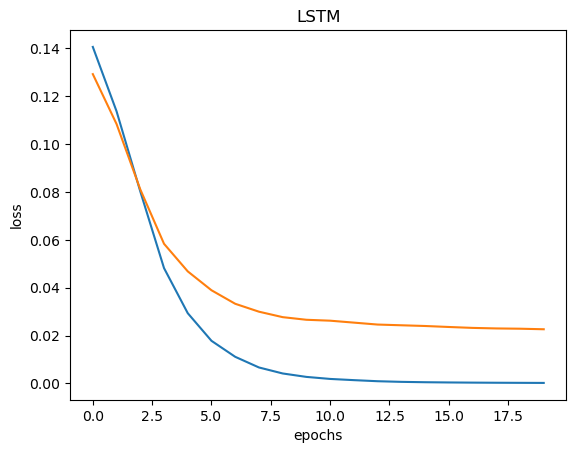

In [14]:
# Build your model here:
LSTM_model = Sequential()
LSTM_model.add(LSTM(50, input_shape=(_X_train.shape[1], _X_train.shape[2]), return_sequences=True))
LSTM_model.add(TimeDistributed(Dense(1)))
LSTM_model.add(Flatten())
LSTM_model.add(Dense(6, activation='softmax'))
LSTM_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
LSTM_history = LSTM_model.fit(_X_train, _Y_train, epochs=20, batch_size=32, validation_data=(_X_val, _Y_val))
plt.plot(LSTM_history.history['loss'])
plt.plot(LSTM_history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('LSTM')
plt.show()

In [15]:
LSTM_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 200, 50)           14600     
                                                                 
 time_distributed_4 (TimeDis  (None, 200, 1)           51        
 tributed)                                                       
                                                                 
 flatten_4 (Flatten)         (None, 200)               0         
                                                                 
 dense_9 (Dense)             (None, 6)                 1206      
                                                                 
Total params: 15,857
Trainable params: 15,857
Non-trainable params: 0
_________________________________________________________________


In [46]:
output = LSTM_model.predict(_X_test)
output = np.argmax(output, axis = 1).reshape(output.shape[0], 1).astype(int)
assert(output.shape == (190, 1))
np.savetxt('lstm_output.csv', output, delimiter=",")

6/6 [==============================] - 1s 33ms/step


### EEGNet

Epoch 1/20
19/19 [==============================] - 4s 74ms/step - loss: 1.7047 - accuracy: 0.3295 - val_loss: 1.6792 - val_accuracy: 0.6184
Epoch 2/20
19/19 [==============================] - 1s 59ms/step - loss: 1.4707 - accuracy: 0.6192 - val_loss: 1.5365 - val_accuracy: 0.8421
Epoch 3/20
19/19 [==============================] - 1s 58ms/step - loss: 1.1702 - accuracy: 0.7483 - val_loss: 1.3677 - val_accuracy: 0.8487
Epoch 4/20
19/19 [==============================] - 1s 63ms/step - loss: 0.9952 - accuracy: 0.7798 - val_loss: 1.2194 - val_accuracy: 0.8553
Epoch 5/20
19/19 [==============================] - 1s 57ms/step - loss: 0.8914 - accuracy: 0.8162 - val_loss: 1.1222 - val_accuracy: 0.8618
Epoch 6/20
19/19 [==============================] - 1s 60ms/step - loss: 0.8094 - accuracy: 0.8444 - val_loss: 1.0523 - val_accuracy: 0.8947
Epoch 7/20
19/19 [==============================] - 1s 58ms/step - loss: 0.7718 - accuracy: 0.8742 - val_loss: 1.0009 - val_accuracy: 0.9342
Epoch 8/20
19

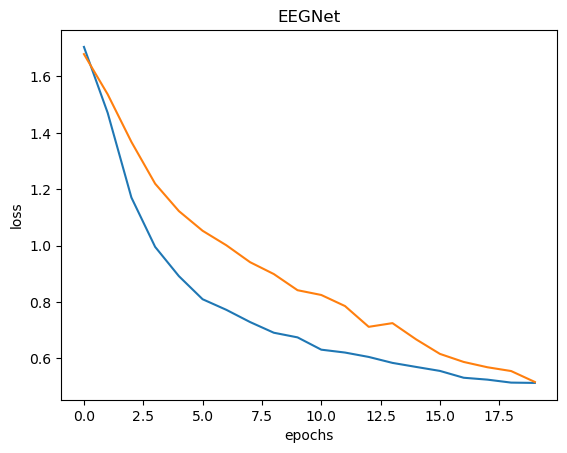

In [54]:
# Build your model here:
F1 = 10
F2 = 20
D = 2
C = X_train.shape[1]
T = X_train.shape[2]
N = 6

EEGNet = Sequential()
# Block 1
EEGNet.add(Conv2D(F1, kernel_size=(1, 64), input_shape=(C, T, 1), activation='linear', padding='same'))
EEGNet.add(BatchNormalization())
EEGNet.add(DepthwiseConv2D(kernel_size=(C, 1), activation='linear', padding='valid', depth_multiplier=D, depthwise_constraint=max_norm(1.)))
EEGNet.add(BatchNormalization())
EEGNet.add(Activation('elu'))
EEGNet.add(AveragePooling2D(pool_size=(1, 4)))
EEGNet.add(Dropout(0.5))
# Block 2
EEGNet.add(SeparableConv2D(F2, kernel_size=(1, 16), activation='linear', padding='same'))
EEGNet.add(BatchNormalization())
EEGNet.add(Activation('elu'))
EEGNet.add(AveragePooling2D(pool_size=(1, 8)))
EEGNet.add(Dropout(0.5))
EEGNet.add(Flatten())
EEGNet.add(Dense(N, activation='softmax', kernel_constraint=max_norm(0.25)))
EEGNet.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
EEGNet_history = EEGNet.fit(X_train, _Y_train, epochs=20, batch_size=32, validation_data=(X_val, _Y_val))
plt.plot(EEGNet_history.history['loss'])
plt.plot(EEGNet_history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('EEGNet')
plt.show()

In [59]:
EEGNet.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 22, 200, 10)       650       
                                                                 
 batch_normalization_24 (Bat  (None, 22, 200, 10)      40        
 chNormalization)                                                
                                                                 
 depthwise_conv2d_8 (Depthwi  (None, 1, 200, 20)       460       
 seConv2D)                                                       
                                                                 
 batch_normalization_25 (Bat  (None, 1, 200, 20)       80        
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 1, 200, 20)        0         
                                                     

In [62]:
output = EEGNet.predict(X_test)
output = np.argmax(output, axis=1).reshape(output.shape[0], 1).astype(int)
assert(output.shape == (190, 1))
np.savetxt('eegnet_output.csv', output, delimiter=",")

6/6 [==============================] - 0s 16ms/step


## Model Competition Part

Epoch 1/20
19/19 [==============================] - 4s 88ms/step - loss: 1.5654 - accuracy: 0.5464 - val_loss: 1.2394 - val_accuracy: 0.8289
Epoch 2/20
19/19 [==============================] - 1s 71ms/step - loss: 1.0873 - accuracy: 0.7831 - val_loss: 0.9087 - val_accuracy: 0.8684
Epoch 3/20
19/19 [==============================] - 1s 77ms/step - loss: 0.8483 - accuracy: 0.8659 - val_loss: 0.8378 - val_accuracy: 0.8882
Epoch 4/20
19/19 [==============================] - 1s 76ms/step - loss: 0.7350 - accuracy: 0.9172 - val_loss: 0.8458 - val_accuracy: 0.9276
Epoch 5/20
19/19 [==============================] - 2s 83ms/step - loss: 0.6813 - accuracy: 0.9040 - val_loss: 0.8698 - val_accuracy: 0.9276
Epoch 6/20
19/19 [==============================] - 1s 79ms/step - loss: 0.6296 - accuracy: 0.9222 - val_loss: 0.8661 - val_accuracy: 0.9342
Epoch 7/20
19/19 [==============================] - 2s 105ms/step - loss: 0.5914 - accuracy: 0.9338 - val_loss: 0.8637 - val_accuracy: 0.9276
Epoch 8/20
1

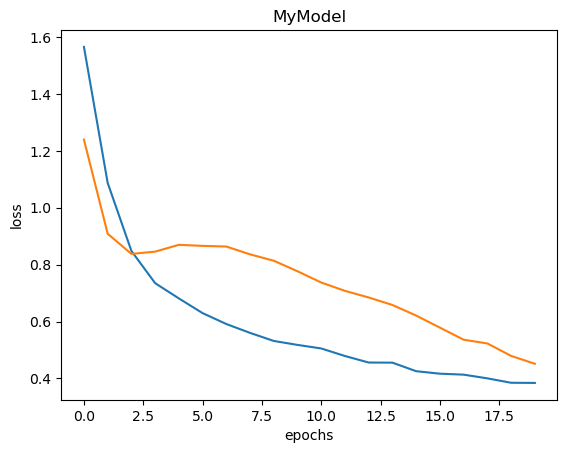

In [12]:
# Build your model here:

F1 = 16
F2 = 24
D = 3
C = X_train.shape[1]
T = X_train.shape[2]
N = 6


Model = Sequential()

Model.add(Conv2D(F1, kernel_size=(1, 64), input_shape=(C, T, 1), padding='same'))
Model.add(BatchNormalization())
Model.add(DepthwiseConv2D(kernel_size=(C, 1), activation='linear', padding='valid', depth_multiplier=D, depthwise_constraint=max_norm(1.)))
Model.add(BatchNormalization())
Model.add(Activation('elu'))
Model.add(AveragePooling2D(pool_size=(1, 4)))
Model.add(Dropout(0.5))

Model.add(Conv2D(F2, kernel_size=(1, 16), activation='linear', padding='same'))
Model.add(BatchNormalization())
Model.add(Activation('elu'))
Model.add(AveragePooling2D(pool_size=(1, 8)))
Model.add(Dropout(0.5))
Model.add(Flatten())

Model.add(Dense(N, activation='softmax', kernel_constraint=max_norm(0.25)))
Model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
Model_history = Model.fit(X_train, _Y_train, epochs=20, batch_size=32, validation_data=(X_val, _Y_val))
plt.plot(Model_history.history['loss'])
plt.plot(Model_history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('MyModel')
plt.show()

In [13]:
output = Model.predict(X_test)
output = np.argmax(output, axis=1).reshape(output.shape[0], 1).astype(int)
assert(output.shape == (190, 1))
np.savetxt('competition_output.csv', output, delimiter=",")

6/6 [==============================] - 0s 19ms/step
